In [1]:
# Utilities
import os
import re
import pickle

# NLP
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwd = stopwords.words('spanish')

# Data
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Graphs
import seaborn as sns

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


In [2]:
base_path = '../data/intents'

files = os.listdir('../data/intents')
df_list = []
for file in files:
  df_temp = pd.read_csv(f'{base_path}/{file}', header=0, names=['question'])
  df_temp['intent'] = file.split('.')[0]
  df_list.append(df_temp)

df = pd.concat(df_list)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df.describe(include="all")

,question,intent
count,300,300
unique,86,9
top,cual es su vision,ubicacion
freq,4,39


In [3]:
all_tokens = [ w for s in df['question'] for w in word_tokenize(s) if w not in stopwd and re.match('\w', w) ]

# Tokens
freq_dist_tokens = nltk.collocations.FreqDist(all_tokens)

# Bigrams
bigrams = nltk.bigrams(all_tokens)
freq_dist_bigrams = nltk.collocations.FreqDist(bigrams)


In [4]:
[ w for s in df['question'] for w in word_tokenize(s) if w not in stopwd and re.match('\w', w) ]

# Tokens
freq_dist_tokens = nltk.collocations.FreqDist(all_tokens)

# Bigrams
bigrams = nltk.bigrams(all_tokens)
freq_dist_bigrams = nltk.collocations.FreqDist(bigrams)


In [5]:
most_common_tokens = freq_dist_tokens.most_common(20)
list_tokens = [w[0] for w in list(most_common_tokens)]
for i in list_tokens:
  df[i] = 0

In [6]:
most_common_bigrams = freq_dist_bigrams.most_common(20)
list_bigrams = [w[0] for w in list(most_common_bigrams)]
for i in list_bigrams:
  df[i] = 0

In [7]:
def transform(arr, col) -> list:
  tokens = [ w for w in word_tokenize(arr[0]) if w not in stopwd and re.match('\w', w) ]
  bigrams = list(nltk.bigrams(tokens))

  for idx, ele in enumerate(col):
    if ele in tokens: 
      arr[idx] = 1
    elif len(bigrams):
      for b in bigrams:
        if ele[0] == b[0] and ele[1] == b[1]:
          arr[idx] = 1

  return arr

In [8]:
col = df.columns
str_col = [str(c) for c in col]
matrix = []
for i in df.index:
  arr = transform(df.iloc[i].array, col)
  matrix.append(arr)

df_train = pd.DataFrame(matrix, columns=str_col)

In [9]:
X = df_train[str_col]
X.drop(columns=['question', 'intent'], inplace=True)

y = df_train['intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
gnb = GaussianNB()
gnb = gnb.fit(X, y) # PROD
# gnb = gnb.fit(X_train, y_train) # DEV
y_pred = gnb.predict(X_test)

print('Accuracy of GBN classifier on training set: {:.2f}%'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GBN classifier on test set: {:.2f}%'
     .format(gnb.score(X_test, y_test)))

Accuracy of GBN classifier on training set: 0.64%
Accuracy of GBN classifier on test set: 0.61%


<AxesSubplot:>

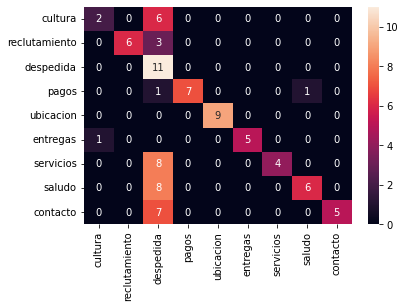

In [11]:
matrix_data = confusion_matrix(y_test, y_pred)
matrix_graph = pd.DataFrame(matrix_data,
  index=df['intent'].unique(),
  columns=df['intent'].unique()
)
sns.heatmap(matrix_graph, annot=True, fmt=".0f" )

In [12]:
print(classification_report(y_test, y_pred, zero_division=0))

               precision    recall  f1-score   support

     contacto       0.67      0.25      0.36         8
      cultura       1.00      0.67      0.80         9
    despedida       0.25      1.00      0.40        11
     entregas       1.00      0.78      0.88         9
        pagos       1.00      1.00      1.00         9
reclutamiento       1.00      0.83      0.91         6
       saludo       1.00      0.33      0.50        12
    servicios       0.86      0.43      0.57        14
    ubicacion       1.00      0.42      0.59        12

     accuracy                           0.61        90
    macro avg       0.86      0.63      0.67        90
 weighted avg       0.86      0.61      0.64        90



In [14]:
pickle.dump({
  "model": gnb,
  "columns": col 
}, open('../model/IchigoModel.v1.pckl','wb'))